In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import numba as nb
import netCDF4 as nc

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')

import analog_utils as ana
import data_utils as du
import graph_utils as gu

from namelist import * 

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

# Import data

In [4]:
# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    base_lon = h5io['base_lon'][...]
    base_lat = h5io['base_lat'][...]
    bc_lon = h5io['bc_lon'][...]
    bc_lat = h5io['bc_lat'][...]
    etopo_bc = h5io['etopo_bc'][...]
    land_mask = h5io['land_mask_base'][...]
    land_mask_bc = h5io['land_mask_bc'][...]

# Figure settings

In [5]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [6]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0.1, 
            'transparent':False}

In [7]:
def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a % b)

# Example plot

In [8]:
# A = cmaps.precip2_15lev(range(15))
# A[0, :3] = 0.85*A[0, :3]
# cmap_pct = colors.ListedColormap(A, 'hist')

A = cmaps.prcp_1(range(15))
A[0, :3] = [0.85, 0.85, 0.85]
A[-1, :3] = [0.55, 0.0, 0.0]
cmap_pct = colors.ListedColormap(A, 'hist')
cmap_pct.set_over([0.35, 0.0, 0.0])

In [9]:
cmap_domain = colors.ListedColormap(A[4:7, :], 'hist')
cmap_terrain = colors.ListedColormap(plt.cm.terrain(np.arange(48, 256)), 'temp_cmap')

In [10]:
edge_bc = [-141, -113.25, 48.25, 60]
r_bc = aspc_cal(edge_bc)

### Load quantile data

In [11]:
# ERA quantiles
CDF_era = np.empty((12, 105, 48, 112)); CDF_era[...] = np.nan
with h5py.File(ERA_dir+'PT_3hour_quantile.hdf', 'r') as h5io:
    CDF_era[..., ~land_mask_bc] = h5io['CDF'][...]
    q_bins = h5io['q'][...]

### ERA quantile vis

In [14]:
r_bc = aspc_cal(edge_bc)

In [30]:
45/15

3.0

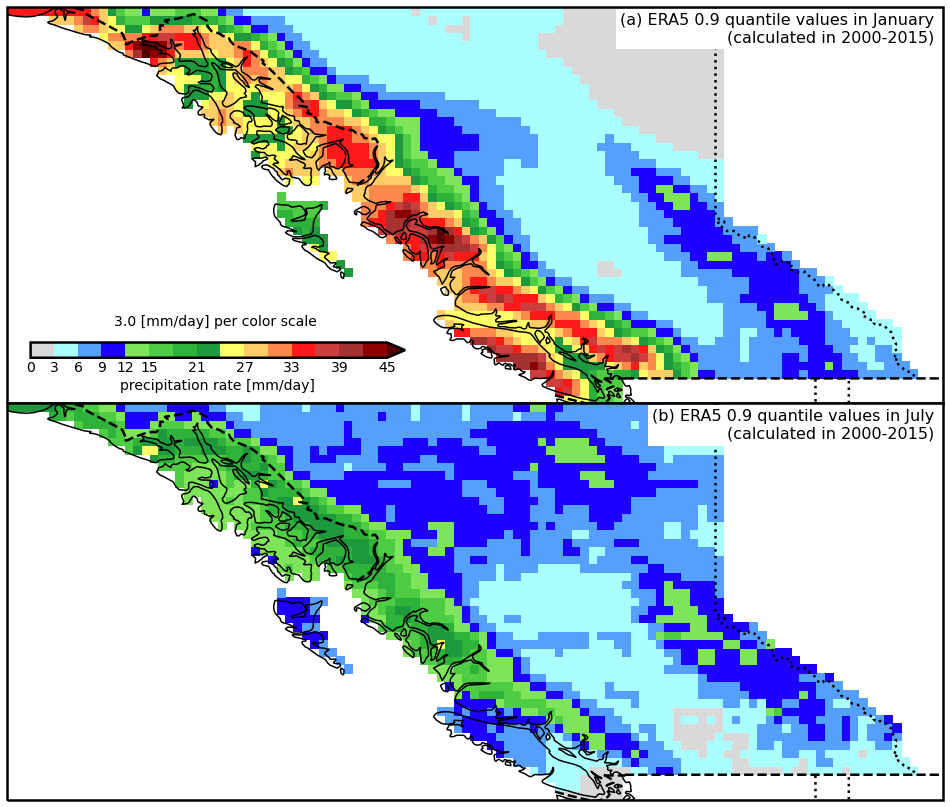

In [55]:
VLIM = [0, 9*5]

fig = plt.figure(figsize=(13, 2*13*r_bc))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], width_ratios=[1,])
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)
AX = [ax1, ax2]

titles = ['(a) ERA5 0.9 quantile values in January\n(calculated in 2000-2015)',
          '(b) ERA5 0.9 quantile values in July\n(calculated in 2000-2015)']

handle_text_title = []
yw = [0.985]*2
for n, ax in enumerate(AX):
    ax.set_extent(edge_bc, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5)
    ax.spines['geo'].set_linewidth(2.5)
    handle_text_title.append(ax.text(0.99, yw[n], titles[n], ha='right', va='top', 
                                     fontsize=16, transform=ax.transAxes, zorder=5))
    
CS = AX[0].pcolormesh(bc_lon, bc_lat, 8*CDF_era[0, 93, ...], vmin=VLIM[0], vmax=VLIM[1], cmap=cmap_pct)
AX[1].pcolormesh(bc_lon, bc_lat, 8*CDF_era[6, 93, ...], vmin=VLIM[0], vmax=VLIM[1], cmap=cmap_pct)
    
for handle in handle_text_title:
    handle.set_bbox(dict(facecolor='w', edgecolor='none', zorder=4))
    
ax_base = fig.add_axes([0.025, 1/2+0.5/13, 1/2.5, 0.5/13])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 3, 6, 9, 12, 15, 21, 27, 33, 39, 45], extend='max', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('precipitation rate [mm/day]', fontsize=14)
CBar.outline.set_linewidth(2.5)


ax_w2 = fig.add_axes([0.01+0.25/2.5, 1/2+1/13+0.01, 0.225, 0.025])
ax_w2.set_axis_off()
ax_w2.text(0.5, 1, '3.0 [mm/day] per color scale', fontsize=14, ha='center', va='top', transform=ax_w2.transAxes);
# Save figure
fig.savefig(fig_dir+'ERA_90_quantile.png', format='png', **fig_keys)

In [17]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

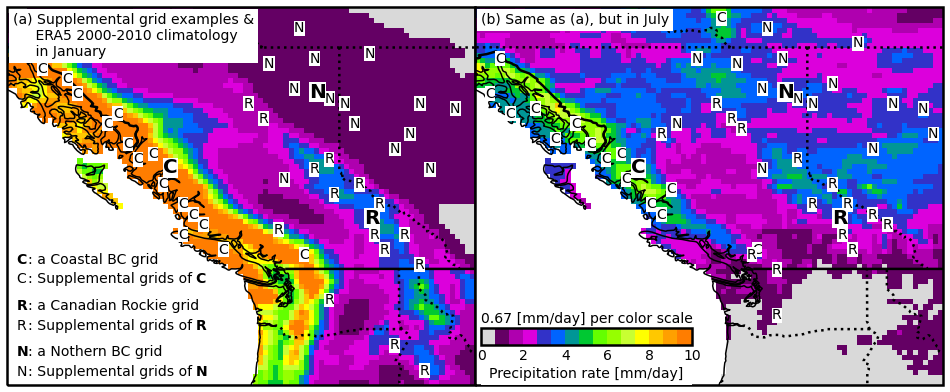

In [21]:
edge = [edge_bc[0]+4.5, edge_bc[1], edge_bc[2]-5, edge_bc[3]+2]

M = ['C', 'N', 'R']
Ix = [95, 110, 85]
Iy = [85, 114, 125]

VMAX = [10, 10]
CS_ = []

fig = plt.figure(figsize=(13, 5.25))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[1, 1])
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

AX = [ax1, ax2]
titles = ['(a) Supplemental grid examples &\n     ERA5 2000-2010 climatology\n     in January', '(b) Same as (a), but in July']

handle_text = []
handle_text_title = []
for n, ax in enumerate(AX):
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5)
    ax.spines['geo'].set_linewidth(2.5)
    handle_text_title.append(ax.text(0.0125, 0.985, titles[n], ha='left', va='top', fontsize=14, transform=ax.transAxes, zorder=5))
    if n == 0: 
        mon = 0
    else:
        mon = 6
        
    CS_.append(ax.pcolormesh(base_lon, base_lat, ERA5_monmean[mon, ...], vmin=0, vmax=VMAX[n], cmap=cmap_pct))
    for i in range(3):
        indx = Ix[i]
        indy = Iy[i]
        SL_indx = SL_xy[mon, indx, indy, :, 0]
        SL_indy = SL_xy[mon, indx, indy, :, 1]

        handle_text.append(ax.text(base_lon[indx, indy], base_lat[indx, indy], M[i], 
                                   fontsize=20, fontweight='bold', zorder=5))
        for j in range(15):
            handle_text.append(ax.text(base_lon[SL_indx[j], SL_indy[j]], base_lat[SL_indx[j], SL_indy[j]], M[i], 
                                       fontsize=14, zorder=4))
for handle in handle_text:
    handle.set_bbox(dict(facecolor='w', pad=0.4, edgecolor='none', zorder=4))
for handle in handle_text_title:
    handle.set_bbox(dict(facecolor='w', edgecolor='none', zorder=4))
    
ax_w = fig.add_axes([0.01, 0.0, 0.225, 0.35])
ax_w.set_axis_off()
ax_w.text(0.0, 1, 'C', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 1, ": a Coastal BC grid", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.85, 'C', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.85, ": Supplemental grids of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.85, 'C', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)

ax_w.text(0.0, 0.65, 'R', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 0.65, ": a Canadian Rockie grid", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.5, 'R', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.5, ": Supplemental grids of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.5, 'R', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)

ax_w.text(0.0, 0.3, 'N', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 0.3, ": a Nothern BC grid", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.15, 'N', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.15, ": Supplemental grids of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.15, 'N', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)

ax_base = fig.add_axes([0.5065, 0.0, 0.225, 0.15])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS_[1], orientation='horizontal', cax=cax) #, ticks=[0, 2, 4, 6, 8, 10]
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Precipitation rate [mm/day]', fontsize=14)
CBar.outline.set_linewidth(2.5)

ax_w2 = fig.add_axes([0.5065, 0.135, 0.05, 0.02])
ax_w2.set_axis_off()
ax_w2.text(0, 1, '0.67 [mm/day] per color scale', ha='left', va='bottom', fontsize=14, transform=ax_w2.transAxes);